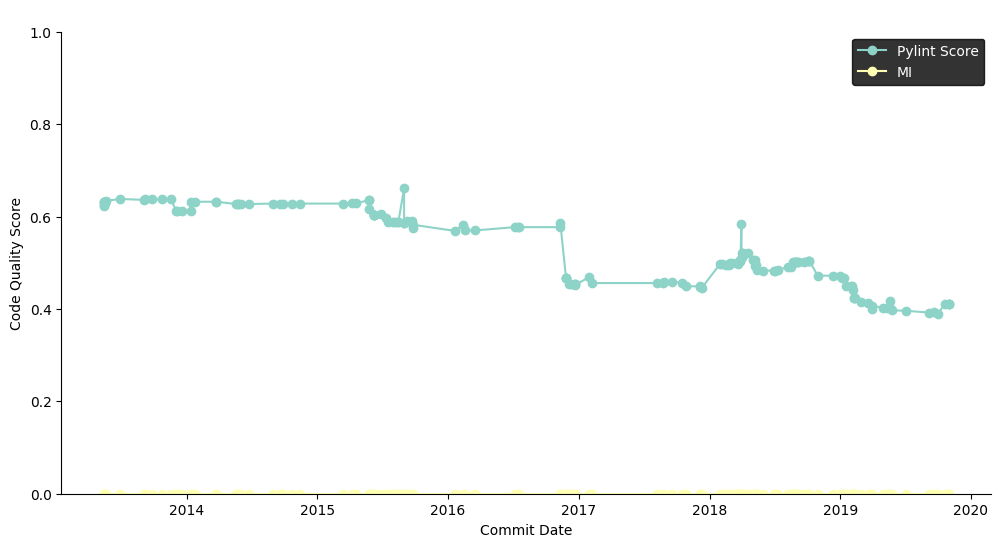

In [6]:
from datetime import datetime, tzinfo

import numpy as np
from build.code_quality_analyzer import calculate_maintainability_index, calculate_maintainability_index_like_radon
from build.database_handler import get_object
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

def plot_file_code_quality(file_id, collection, metric_names=[]):
    """
    Plot the code quality metrics for a specific file in the repository
    Args:
        repo_name (str): The name of the repository of the file file belongs to
        file_id (str): The ID of the file to plot the code quality metrics for
    """
    file = get_object(file_id, collection)
    if not file:
        print(f"File with ID {file_id} not found in collection {collection}.")
        return
    
    # Setup the metrics dictionary
    metrics = {}
    input_metrics = []
    if "mi" in metric_names:
        input_metrics = (["cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"] + metric_names) # TODO Fix error where MI is in wrong order
    else: 
        input_metrics = metric_names
    default_metric_structure = {}
    for metric in input_metrics:
        default_metric_structure[metric] = None

    previous_time = None
    previous_complete_time = None
    for attribute in file["attributes"]:
        if attribute["name"] not in input_metrics:
            continue
        time = attribute["time"]
        name = attribute["name"]
        value = attribute["value"]

        if time not in list(metrics.keys()):
            metrics[time] = default_metric_structure.copy()
            if previous_time is not None and previous_time != time:
                previous_complete_time = list(metrics.keys())[-3] if len(metrics) > 2 else None
                for metric, metric_value in metrics[previous_time].items():
                    if metric_value is None and metric != "mi":
                        metrics[previous_time][metric] = metrics[previous_complete_time][metric]
                    elif metric == "mi":
                        if all(metrics[previous_time][m] is not None for m in input_metrics if m != "mi"):
                            metrics[previous_time][metric] = calculate_maintainability_index(
                                metrics[previous_time]["N_1"],
                                metrics[previous_time]["N_2"],
                                metrics[previous_time]["theta_1"],
                                metrics[previous_time]["theta_2"],
                                metrics[previous_time]["cc"],
                                metrics[previous_time]["sloc"]
                            )/100
                        else: 
                            print(f"ERROR: Not all required metrics for MI calculation are available at {previous_time}.")
        metrics[time][name] = int(value) if name != "pylint_score" else float(value)
        previous_time = time

    # After going through all changed attributes, ensure that the last time point has also all metrics filled (Not accounted for in loop)
    for metric, metric_value in metrics[previous_time].items():
        if metric_value is None:
            metrics[previous_time][metric] = metrics[previous_complete_time][metric]

    # Plotting the metrics
    plt.figure(figsize=(12, 6))
    datetimes = [datetime.fromisoformat(ts) for ts in sorted(metrics.keys())]
    commit_dates = np.array(datetimes)
    for metric in metric_names:
        values = np.array([float(metrics[date][metric]) for date in sorted(metrics.keys())])
        if len(metric.split("_")) > 1:
            metric_label = metric.replace("_", " ").title()
        else:
            metric_label = metric.upper()
        plt.plot(commit_dates, values, label=metric_label, marker="o", linestyle="-")

    plt.title(f"Code Quality Metrics Over Time for {file['_id']}")
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False

    plt.xlabel("Commit Date")
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.ylabel("Code Quality Score")
    if "mi" in metric_names or "pylint_score" in metric_names:
        plt.ylim(0, 1)
    else:
        plt.ylim(0, max([max(metrics[date][metric] for date in metrics) for metric in metric_names]) * 1.1)

    plt.legend()
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['legend.edgecolor'] = 'black'
    plt.rcParams['legend.facecolor'] = 'black'
    plt.show()

plot_file_code_quality("lib/matplotlib/pyplot.py", "matplotlib", ["pylint_score", "mi"])

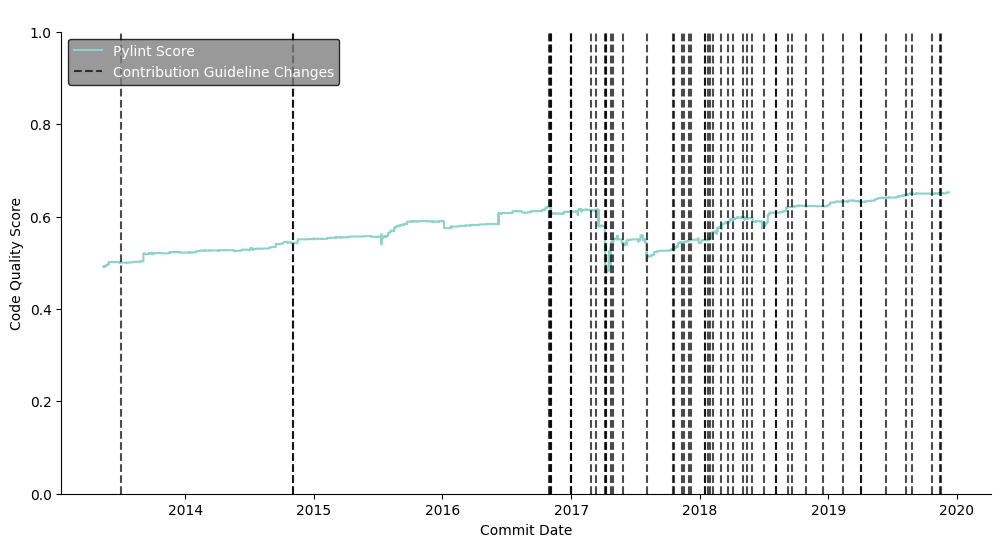

In [2]:
import matplotlib
from datetime import datetime
from datetime import tzinfo

from pytz import utc
from build.code_quality_visualizer import plot_repo_code_quality_fast

plot_repo_code_quality_fast("matplotlib", "2017")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


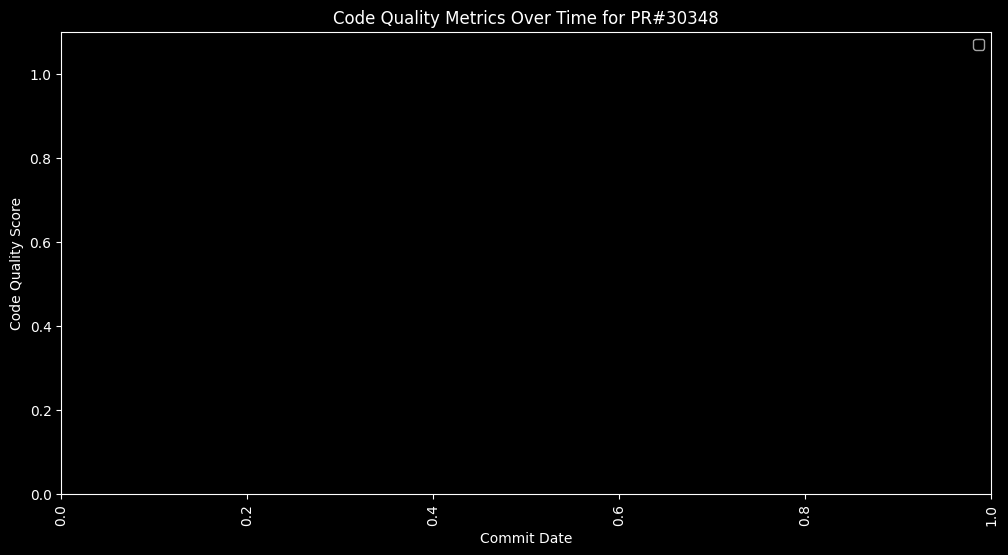

In [2]:
from matplotlib.colors import hex2color
from build.code_quality_analyzer import calculate_maintainability_index, get_attribute_value_at_time
from build.database_handler import get_object
from datetime import datetime
from matplotlib import pyplot as plt

def plot_pull_request_code_quality(pull_request_id, collection, metric_names=[]):
    """
    Plot the code quality metrics for a specific pull request in the repository
    Args:
        pull_request_id (str): The ID of the pull request to plot the code quality metrics for
    """
    pull_request = get_object(pull_request_id, collection)
    if not pull_request:
        print(f"Pull request with ID {pull_request_id} not found in collection {collection}.")
        return
    metrics = {}
    input_metrics = []
    if "mi" in metric_names:
        input_metrics = (["cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"] + metric_names) # TODO Fix error where MI is in wrong order
    else: 
        input_metrics = metric_names
    default_metric_structure = {}
    for metric in input_metrics:
        default_metric_structure[metric] = None

    for relationship in pull_request["relationships"]:
        commit, file_object = None, None
        if relationship["qualifier"] == "formalises":
            commit = get_object(relationship["qualifier"], collection)
        elif relationship["qualifier"] == "aggregates":
            file_object = get_object(relationship["qualifier"], collection)
        if commit is not None and len(commit["attributes"]) > 0:
            commit_time = datetime.fromisoformat(commit["attributes"][0]["time"]).replace(tzinfo=None)
            metrics[commit_time] = default_metric_structure.copy()
        else:
            commit_time = datetime.now()

        if file_object is not None and file_object["_id"].find(".py") != -1:
            for metric, metric_value in metrics[commit_time].items():
                if metric_value is None and metric != "mi":
                    metrics[commit_time][metric] = get_attribute_value_at_time(file_object["_id"], metric, commit_time, collection) 
                elif metric == "mi":
                    if all(metrics[commit_time][m] is not None for m in input_metrics if m != "mi"):
                        metrics[commit_time][metric] = calculate_maintainability_index(
                            metrics[commit_time]["N_1"],
                            metrics[commit_time]["N_2"],
                            metrics[commit_time]["theta_1"],
                            metrics[commit_time]["theta_2"],
                            metrics[commit_time]["cc"],
                            metrics[commit_time]["sloc"]
                        )/100
                    else: 
                        print(f"ERROR: Not all required metrics for MI calculation are available at {commit_time}.")
            # Get all files modified in all commits and then create average of metrics for files per commit
    plt.figure(figsize=(12, 6))
    plt.xlabel("Commit Date")
    plt.ylabel("Code Quality Score")
    plt.title(f"Code Quality Metrics Over Time for PR#{pull_request['_id']}")
    plt.xticks(rotation=90)
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()

plot_pull_request_code_quality("30348", "matplotlib", ["pylint_score", "mi", "cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"])

In [ ]:
from build.code_quality_visualizer import split_code_quality_per_guideline_change

# TODO fix or delete
split_code_quality_per_guideline_change("matplotlib", 1000)

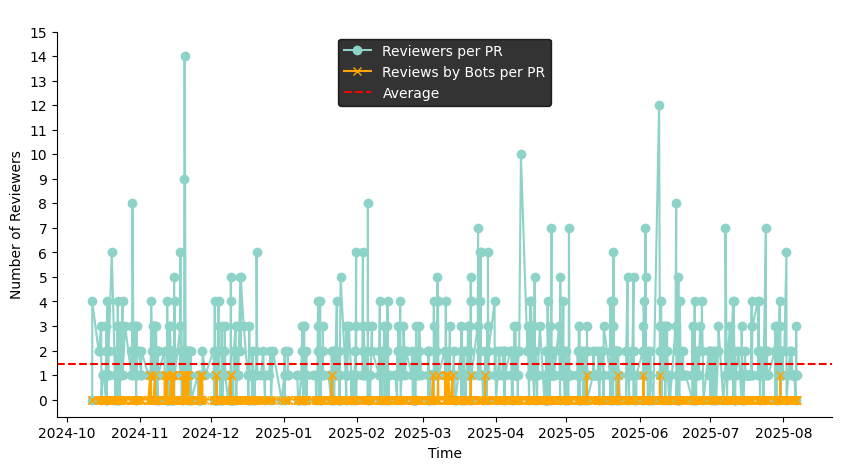

In [7]:
from build.contribution_process_analyzer import pull_request_reviewer_analysis
from build.database_handler import get_pull_requests

collection = "edx-platform"

pull_requests = get_pull_requests(collection)
ids = [pull_request["_id"] for pull_request in pull_requests]
pull_request_reviewer_analysis(ids, collection, True)

In [5]:
from build.contribution_process_analyzer import pull_request_open_time_analysis

pull_request_open_time_analysis(ids, collection, True)

KeyError: 'close'

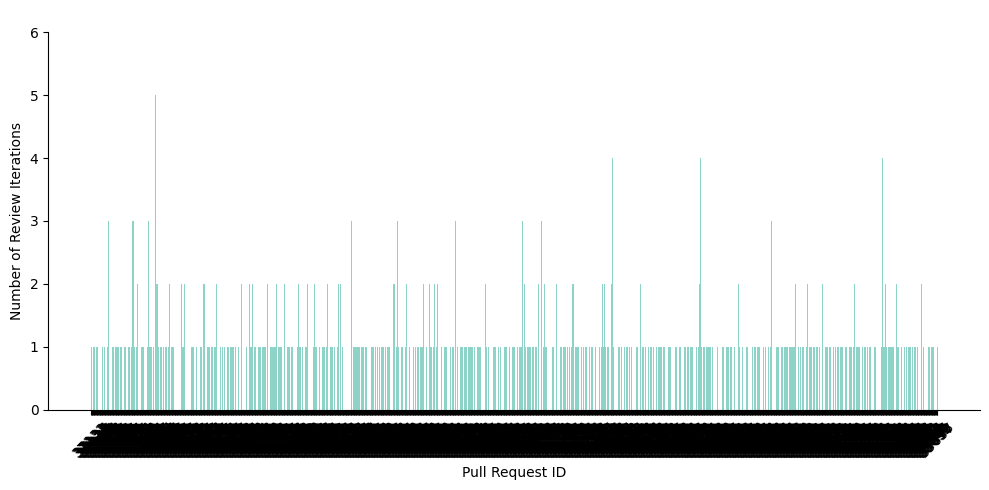

In [6]:
from build.contribution_process_analyzer import pull_request_review_iterations

pull_request_review_iterations(ids, collection, True)

ERROR: No object found for id: 99aef4912fb08fa50044dd052e3ea6a2fa7f3acd
ERROR: No object found for id: f5ad6ad7b3ae7ce1e0365b7e14a01d527d8af10f
ERROR: No object found for id: fe9be55dcd0091c41a681d471749f1c90121cd7b
ERROR: No object found for id: GitHub
ERROR: No object found for id: feafda08e8b49c832744a2cc886506457e2aa2cd
ERROR: No object found for id: adrinjalali
ERROR: No object found for id: 50bf879005fb7b43d47db072f0803dabca2d6893
ERROR: No object found for id: ec89008f3e4c314732255952643bdf0804955a0c
ERROR: No object found for id: 2833590bc726f722f9c4b387da5e45cc93c289a5
ERROR: No object found for id: Lock file bot
ERROR: No object found for id: 64f1a96fe4b9ec2ea1c682aa2f1732896e5a2b33
ERROR: No object found for id: Lock file bot
ERROR: No object found for id: 65b87413872bce85287dbcadb2a9ff5faa904082
ERROR: No object found for id: Lock file bot
ERROR: No object found for id: 21453123b1e167a4ff197226819224db81aaae57
ERROR: No object found for id: c9cb52a8130cbc6806b410a0a5a2df400

/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/Bachelor-Code/build/contribution_process_miner.py:106: FutureWarning: Parsed string "2025-08-04T23:22:33ZZ" included an un-recognized timezone "ZZ". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], utc=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['case:concept:name', 'event_id', 'concept:name', 'time:timestamp',
       'attributes', 'relationships'],
      dtype='object')


parsing log, completed traces :: 100%|██████████| 118/118 [00:00<00:00, 1337.81it/s]


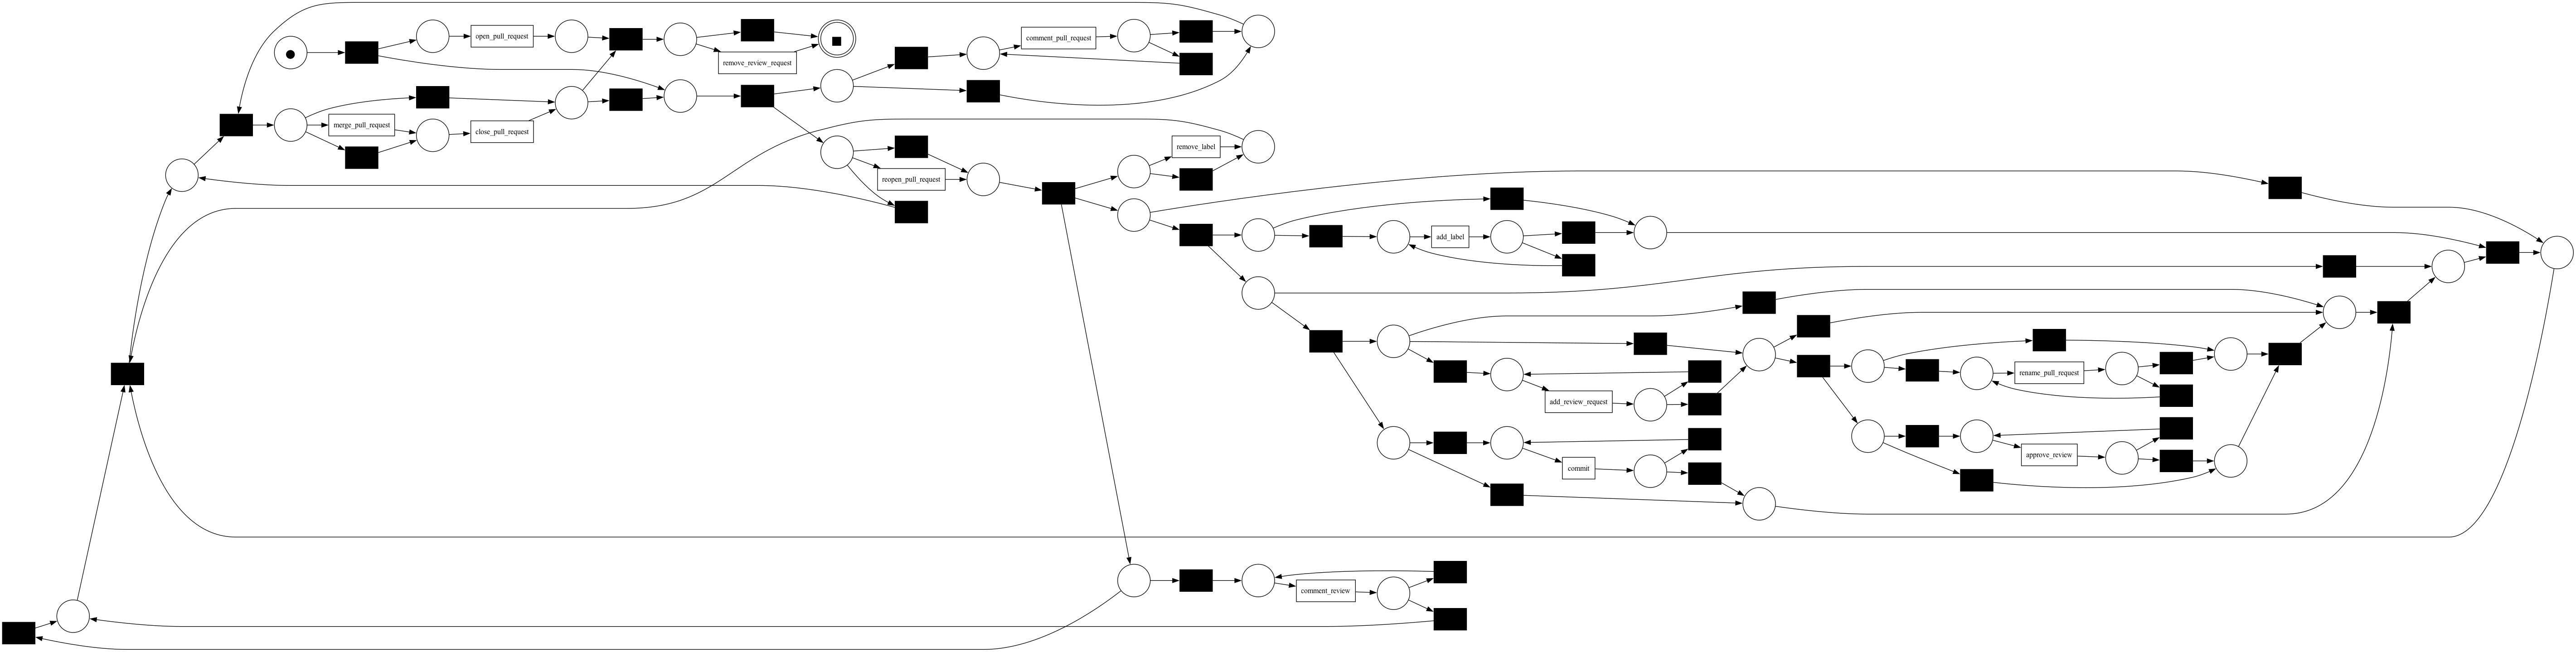

In [1]:
import json
from build.contribution_process_analyzer import get_ocel_data
from build.contribution_process_miner import flatten_ocel2, visualise_xes_as

collection = "scikit-learn"

path = get_ocel_data(collection)
with open(path) as f:
    ocel = json.load(f)
flat_dataframe = flatten_ocel2(ocel, object_type="pull_request", collection=collection)
visualise_xes_as("petri_net", flat_dataframe, collection)

In [1]:
import json
from build.database_handler import insert_ocel_object, insert_ocel_event

collection = "edx-platform"

path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/Bachelor-Code/Exports/{collection}-OCEL.json"

with open(path) as f:
    ocel = json.load(f)

for object in ocel["objects"]:
    insert_ocel_object(object, collection)

for event in ocel["events"]:
    insert_ocel_event(event, collection)